In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from pprint import pprint

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Climate Analysis and Exploration
### Precipitation Analysis

In [10]:
inspector = inspect(engine)
measure_col = [c['name'] for c in inspector.get_columns('measurement')]
station_col = [c['name'] for c in inspector.get_columns('station')]
print(f'Measurement Columns: {measure_col}')
print(f'Station Columns: {station_col}')

Measurement Columns: ['id', 'station', 'date', 'prcp', 'tobs']
Station Columns: ['id', 'station', 'name', 'latitude', 'longitude', 'elevation']


#### Pandas Method
Call data and manipulate using pandas

In [11]:
# data_dateprcp = engine.execute('SELECT date, prcp FROM measurement order by date').fetchall()
# df_prcp_date = pd.DataFrame(data_dateprcp, columns=['Date','Precipitation'])
# df_prcp_date['Date'] = pd.to_datetime(df_prcp_date['Date'])
# last12_prcp = df_prcp_date.set_index('Date').last('12M').sort_values('Date')
# last12_prcp = df_prcp_date.set_index('Date').last('12M').sort_values('Date')

#### SqlAlchemy Method
Call data and manipulate using sqlalchemy functions

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
data_dateprcp = [Measurement.date, Measurement.prcp]
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
last_12mo = dt.datetime.strptime(latest_date,"%Y-%m-%d") - dt.timedelta(days=365)
last_12mo = dt.datetime.strftime(last_12mo,"%Y-%m-%d")
print(last_12mo+", "+latest_date)
df_prcp_date = session.query(*data_dateprcp).\
                filter(Measurement.date.between(last_12mo,latest_date)).\
                order_by(Measurement.date).all()
last12_prcp = pd.DataFrame(df_prcp_date, columns=['Date', 'Precipitation']).set_index('Date')

2016-08-23, 2017-08-23


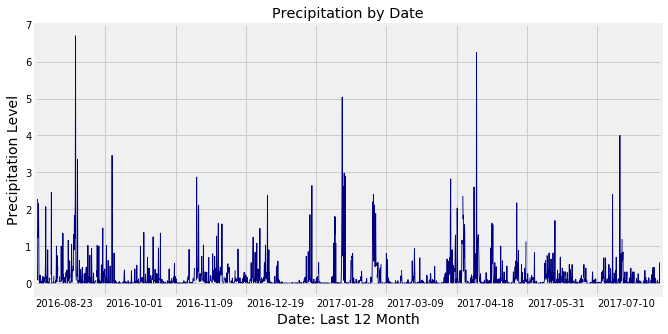

In [13]:
last12_prcp.plot(title='Precipitation by Date',lw=0.9,colormap='jet',
                 legend=False,figsize=(10,5))
plt.ylabel('Precipitation Level',fontsize=14)
plt.xlabel('Date: Last 12 Month',fontsize=14)
plt.xticks(ha='left')
plt.savefig('Images/Plot01_Precipitation_by_date.png')
plt.show()

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
summary_prcp = last12_prcp.describe()
summary_prcp

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


### Station Analysis

In [15]:
# Design a query to show how many stations are available in this dataset?
print(f'Measurement Columns: {measure_col}')
print(f'Station Columns: {station_col}')

Measurement Columns: ['id', 'station', 'date', 'prcp', 'tobs']
Station Columns: ['id', 'station', 'name', 'latitude', 'longitude', 'elevation']


In [16]:
# Check to see overlapping stations and Count Unique

# Decided to do unique check rather than Station's Primary Key ID
station_unique = session.query(Measurement.station).group_by(Measurement.station).count()
print(f"There are total {station_unique} stations")

There are total 9 stations


In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_active_m = session.query(Measurement.station,func.count(Measurement.station)).\
                group_by(Measurement.station).\
                order_by(func.count(Measurement.station).desc()).all()
station_active_m

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
sel_tobs = [func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)]
temp_mostactive = session.query(*sel_tobs).filter(Measurement.station==station_active_m[0][0]).all()
temp_mostactive

[(54.0, 85.0, 71.66378066378067)]

In [19]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_tobs_m = session.query(Measurement.tobs).\
                    filter(Measurement.station==station_active_m[0][0]).\
                    filter(Measurement.date.between(last_12mo,latest_date)).all()
df_tobs_12mo = pd.DataFrame(station_tobs_m,columns=['Temperature'])

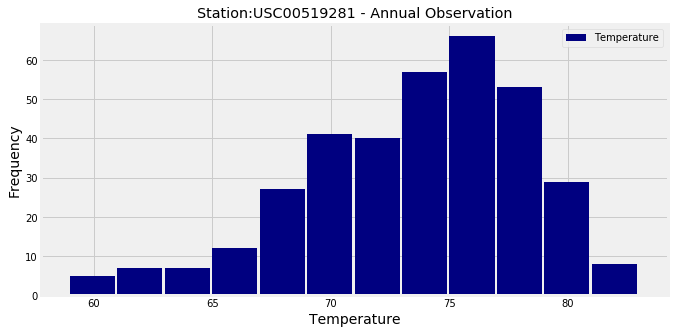

In [20]:
df_tobs_12mo.plot(kind='hist',bins=12,width=1.9,title="Station:USC00519281 - Annual Observation",
                  colormap='jet',figsize=(10,5))

plt.ylabel('Frequency',fontsize=14)
plt.xlabel('Temperature',fontsize=14)
plt.savefig('Images/Plot02_Temp_by_frequency.png')
plt.show()

## Climate App
For 'Climate App' refer to app.py

# Optional: Other Recommended Analysis
## Temperature Analysis I

In [80]:
from scipy import stats

In [38]:
june_avgtobs = session.query(func.avg(Measurement.tobs)).\
            filter(func.strftime("%m",Measurement.date)== '06').\
            order_by(Measurement.date).all()[0][0]

dec_avgtobs = session.query(func.avg(Measurement.tobs)).\
            filter(func.strftime("%m",Measurement.date)== '12').\
            order_by(Measurement.date).all()[0][0]

In [40]:
print(f"June average temp: {june_avgtobs}")
print(f"Dec average temp: {dec_avgtobs}")

June average temp: 74.94411764705882
Dec average temp: 71.04152933421226


In [81]:
june_tobs = session.query(Measurement.tobs).\
            filter(func.strftime("%m",Measurement.date)== '06').\
            order_by(Measurement.date).all()
sem_june = sem(np.ravel(june_tobs))
print(sem_june)
print(len(june_tobs))

dec_tobs = session.query(Measurement.tobs).\
            filter(func.strftime("%m",Measurement.date)== '12').\
            order_by(Measurement.date).all()
sem_dec = sem(np.ravel(dec_tobs))
print(sem_dec)
print(len(dec_tobs))

0.0790039680627534
1700
0.09617577341524217
1517


### Determine Significance
Perform independent t-test with equal variance.
June and December are half an year apart season, reason for independent t-test.
Records(data) are received from set stations over years, data are equal in variance.

The null hypothesis for the independent t-test is that the temperature means from the June and December are equal(similar)
H0: u1 = u2

In [85]:
d = {'June':[june_avgtobs,sem_june,len(june_tobs)], 'Dec':[dec_avgtobs,sem_dec,len(dec_tobs)]}
df_ttest = pd.DataFrame(d,index=['Mean','SD','N'])

In [86]:
df_ttest

,June,Dec
Mean,74.944118,71.041529
SD,0.079004,0.096176
N,1700.000000,1517.000000


In [90]:
t,p = stats.ttest_ind_from_stats(june_avgtobs,sem_june,len(june_tobs),dec_avgtobs,sem_dec,len(dec_tobs))

In [92]:
if p < 0.05:
    print('Reject null hypothesis. Accept alternative that difference between June and December temp is significant')
else:
    print('Accept null hypothesis.')

Reject null hypothesis. Accept alternative that difference between June and December temp is significant


## Temperature Analysis II

In [157]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [158]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
calc_temps(last_12mo,latest_date)

[(58.0, 74.59058295964125, 87.0)]

<IPython.core.display.Javascript object>


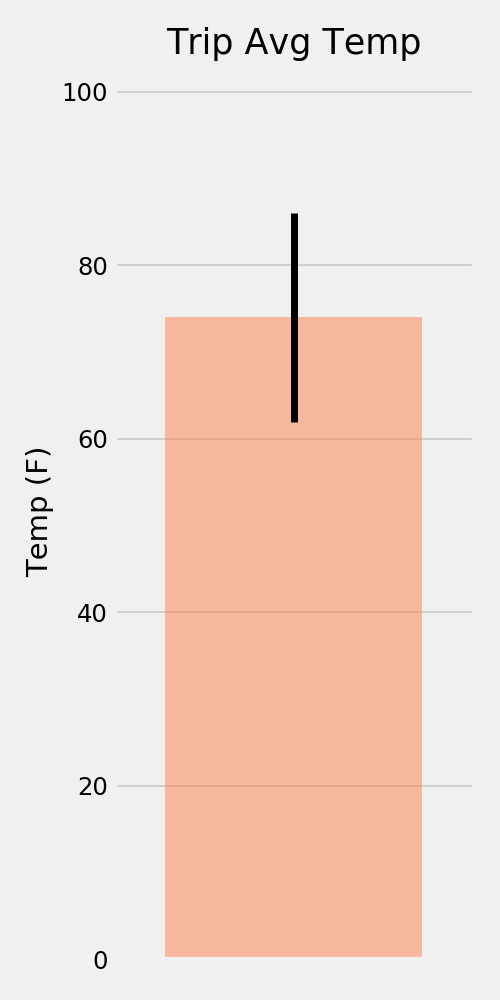

In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [19]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.31), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.25), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.1), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.060000000000000005), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)]


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


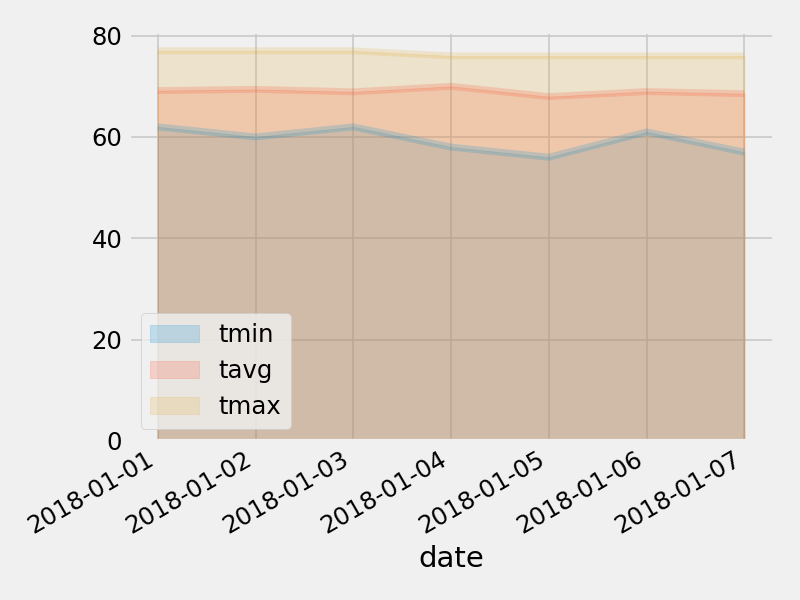

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
